In [1]:
import baostock as bs
import pandas as pd
from IPython.display import display

#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

#### 获取沪深A股历史K线数据 ####
# 详细指标参数，参见“历史行情指标参数”章节；“分钟线”参数与“日线”参数不同。“分钟线”不包含指数。
# 分钟线指标：date,time,code,open,high,low,close,volume,amount,adjustflag
# 周月线指标：date,code,open,high,low,close,volume,amount,adjustflag,turn,pctChg
rs = bs.query_history_k_data_plus("sh.000300",
    "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST",
    start_date='2005-04-08', end_date='2025-04-01',
    frequency="d", adjustflag="3")
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

#### 结果集输出到csv文件 ####   
result.to_csv("./hs300.csv", index=False)
display(result)

#### 登出系统 ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success


,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST
0,2005-04-08,sh.000300,984.6650,1003.6990,979.5290,1003.4450,984.7330,1476252600,9151349808.0000,3,0.014011,1,1.900214,0
1,2005-04-11,sh.000300,1003.8790,1008.7350,992.7730,995.4210,1003.4450,1593606600,10436232248.0000,3,0.015125,1,-0.799644,0
2,2005-04-12,sh.000300,993.7110,993.7110,978.2040,978.6970,995.4210,1022619300,6479563495.0000,3,0.009705,1,-1.680093,0
3,2005-04-13,sh.000300,987.9500,1006.4990,987.9500,1000.9000,978.6970,1607168700,10029602129.0000,3,0.015239,1,2.268629,0
4,2005-04-14,sh.000300,1004.6400,1006.4160,985.5780,986.9750,1000.9000,1294571000,7813424514.0000,3,0.012275,1,-1.391253,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4850,2025-03-26,sh.000300,3930.2073,3942.0260,3916.8607,3919.3566,3932.2951,13116418700,220943164486.2000,3,0.402191,1,-0.329032,0
4851,2025-03-27,sh.000300,3911.3841,3952.9852,3903.6520,3932.4117,3919.3566,12679373800,232173613774.0000,3,0.388788,1,0.333093,0
4852,2025-03-28,sh.000300,3930.7763,3934.2336,3907.3840,3915.1662,3932.4117,12635621400,213379194289.3000,3,0.387446,1,-0.438548,0
4853,2025-03-31,sh.000300,3905.9815,3928.4482,3872.4030,3887.3056,3915.1662,16679852300,268480316572.3000,3,0.511454,1,-0.711607,0


logout success!


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os


# ========== 1. 数据加载 ==========
print("加载数据...")
data = pd.read_csv('./hs300.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

data_cleaned = data.drop(columns=['date'])  

target = 'close'
features = data.drop(columns=[target, 'date']).values
X = features
y = data[target].values.reshape(-1, 1)

# ========== 2. 数据归一化 ==========
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print("✅ 检查反归一化后数据")
print("val_predicted_prices contains NaN:", np.isnan(val_predicted_prices).any())
print("val_real_prices contains NaN:", np.isnan(val_real_prices).any())

# ========== 3. 构造序列 ==========
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, time_steps)

# ========== 4. 数据增强函数 ==========
def moving_average_smoothing(data, window_size=3):
    smoothed_data = np.empty_like(data)
    for col in range(data.shape[1]):
        smoothed_data[:, col] = np.convolve(data[:, col], np.ones(window_size) / window_size, mode='same')
    return smoothed_data

def random_noise(data, noise_factor=0.01):
    noise = noise_factor * np.random.randn(*data.shape)
    return data + noise

def time_series_shift(data, max_shift=3):
    shift = np.random.randint(-max_shift, max_shift + 1)
    if shift > 0:
        return np.vstack([np.zeros((shift, data.shape[1])), data[:-shift]])
    elif shift < 0:
        return np.vstack([data[-shift:], np.zeros((-shift, data.shape[1]))])
    else:
        return data


def data_augmentation(X, y, num_augmentations=5):
    X_augmented, y_augmented = [], []
    for i in range(len(X)):
        X_augmented.append(X[i])
        y_augmented.append(y[i])
        for _ in range(num_augmentations):
            X_smooth = moving_average_smoothing(X[i])
            X_noisy = random_noise(X_smooth)
            X_shifted = time_series_shift(X_noisy)
            X_augmented.append(X_shifted)
            y_augmented.append(y[i])
    return np.nan_to_num(np.array(X_augmented)), np.array(y_augmented)


# ========== 5. 划分训练/测试集并增强 ==========
X_train_full, X_test, y_train_full, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)
X_train_full_augmented, y_train_full_augmented = data_augmentation(X_train_full, y_train_full)

print("✅ 检查数据增强后的训练数据")
print("X_train_full_augmented contains NaN:", np.isnan(X_train_full_augmented).any())
print("y_train_full_augmented contains NaN:", np.isnan(y_train_full_augmented).any())

print(f"Original training data shape: {X_train_full.shape}")
print(f"Augmented training data shape: {X_train_full_augmented.shape}")

# ✅ 创建保存图表的文件夹
import os
os.makedirs('./figures', exist_ok=True)
# ========== 6. 交叉验证训练 ==========
tscv = TimeSeriesSplit(n_splits=5)
mse_scores, rmse_scores, mae_scores, r2_scores = [], [], [], []

for fold, (train_index, val_index) in enumerate(tscv.split(X_train_full_augmented)):
    print(f"Fold {fold + 1}")

    X_train, X_val = X_train_full_augmented[train_index], X_train_full_augmented[val_index]
    y_train, y_val = y_train_full_augmented[train_index], y_train_full_augmented[val_index]

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    # 可视化训练曲线
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label=f'Fold {fold + 1} - Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label=f'Fold {fold + 1} - Validation Loss', color='orange', linestyle='--', linewidth=2)
    plt.title(f'Fold {fold + 1} - Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./figures/loss_fold_{fold + 1}.svg')
    plt.close()

    # gpt检验
    print("val_real_prices contains NaN:", np.isnan(val_real_prices).any())
    print("val_predicted_prices contains NaN:", np.isnan(val_predicted_prices).any())
    print("val_predicted_prices sample:", val_predicted_prices[:5])


    # 在验证集上评估
    val_predictions = model.predict(X_val)
    print("✅ 检查模型预测输出")
    print("val_predictions contains NaN:", np.isnan(val_predictions).any())

    val_predicted_prices = scaler_y.inverse_transform(val_predictions)
    val_real_prices = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    
    # 可选加的 NaN 掩码处理
    mask = ~np.isnan(val_real_prices).flatten() & ~np.isnan(val_predicted_prices).flatten()
    val_mse = mean_squared_error(val_real_prices[mask], val_predicted_prices[mask])

    val_mse = mean_squared_error(val_real_prices, val_predicted_prices)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(val_real_prices, val_predicted_prices)
    val_r2 = r2_score(val_real_prices, val_predicted_prices)

    mse_scores.append(val_mse)
    rmse_scores.append(val_rmse)
    mae_scores.append(val_mae)
    r2_scores.append(val_r2)

# ========== 7. 输出交叉验证平均结果 ==========
print(f"Mean MSE: {np.mean(mse_scores)}")
print(f"Mean RMSE: {np.mean(rmse_scores)}")
print(f"Mean MAE: {np.mean(mae_scores)}")
print(f"Mean R²: {np.mean(r2_scores)}")


加载数据...
✅ 检查反归一化后数据
val_predicted_prices contains NaN: False
val_real_prices contains NaN: False
✅ 检查数据增强后的训练数据
X_train_full_augmented contains NaN: False
y_train_full_augmented contains NaN: False
Original training data shape: (3836, 60, 11)
Augmented training data shape: (23016, 60, 11)
Fold 1
Epoch 1/100
120/120 [==============================] - 8s 42ms/step - loss: 0.0845 - mae: 0.1557 - val_loss: 0.0215 - val_mae: 0.0369
Epoch 2/100
120/120 [==============================] - 4s 36ms/step - loss: 0.0274 - mae: 0.0653 - val_loss: 0.0190 - val_mae: 0.0356
Epoch 3/100
120/120 [==============================] - 4s 37ms/step - loss: 0.0236 - mae: 0.0579 - val_loss: 0.0176 - val_mae: 0.0379
Epoch 4/100
120/120 [==============================] - 4s 36ms/step - loss: 0.0208 - mae: 0.0528 - val_loss: 0.0161 - val_mae: 0.0399
Epoch 5/100
120/120 [==============================] - 4s 38ms/step - loss: 0.0182 - mae: 0.0484 - val_loss: 0.0155 - val_mae: 0.0469
Epoch 6/100
120/120 [============

KeyboardInterrupt: 

 6/30 [=====>........................] - ETA: 0s

d:\anaconda\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 0s 12ms/step


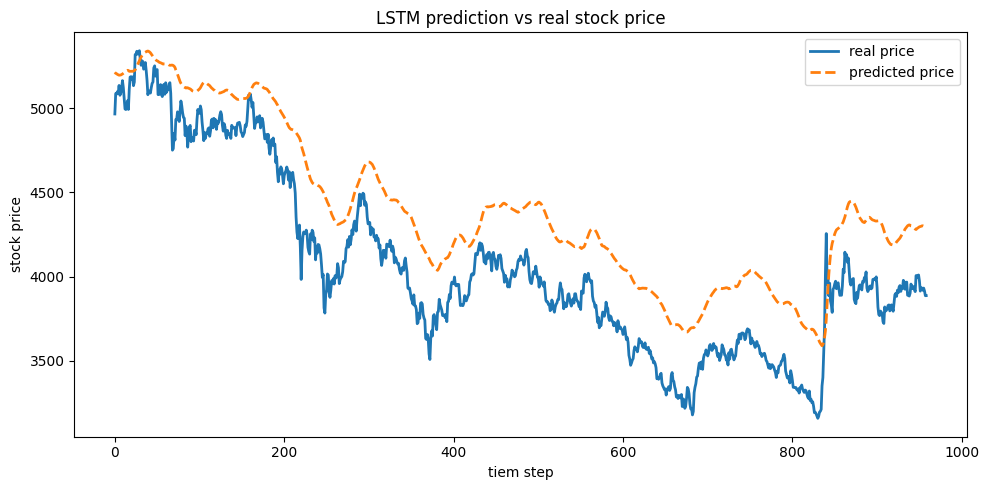

In [14]:
model.save('lstm_final_model.h5')
import pickle
with open('cv_results.pkl', 'wb') as f:
    pickle.dump((mse_scores, rmse_scores, mae_scores, r2_scores), f)

final_predictions = model.predict(X_test)
final_predicted_prices = scaler_y.inverse_transform(final_predictions)
final_real_prices = scaler_y.inverse_transform(y_test)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(final_real_prices, label='real price', linewidth=2)
plt.plot(final_predicted_prices, label='predicted price', linestyle='--', linewidth=2)
plt.title('LSTM prediction vs real stock price')
plt.xlabel('tiem step')
plt.ylabel('stock price')
plt.legend()
plt.tight_layout()
plt.show()


📌 项目名称：基于LSTM的沪深300股价预测
📅 模型训练时间：你自己加上时间戳哦
📈 使用模型：Keras Sequential LSTM x2 + Dropout + Dense
📦 数据增强：平滑 + 加噪 + 时间错位
训练样本数（增强前）：3836
训练样本数（增强后）：23016
LSTM 时间步长：60
特征维度数：11
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 60, 50)            12400     
                                                                 
 dropout_22 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_23 (Dropout)        (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3

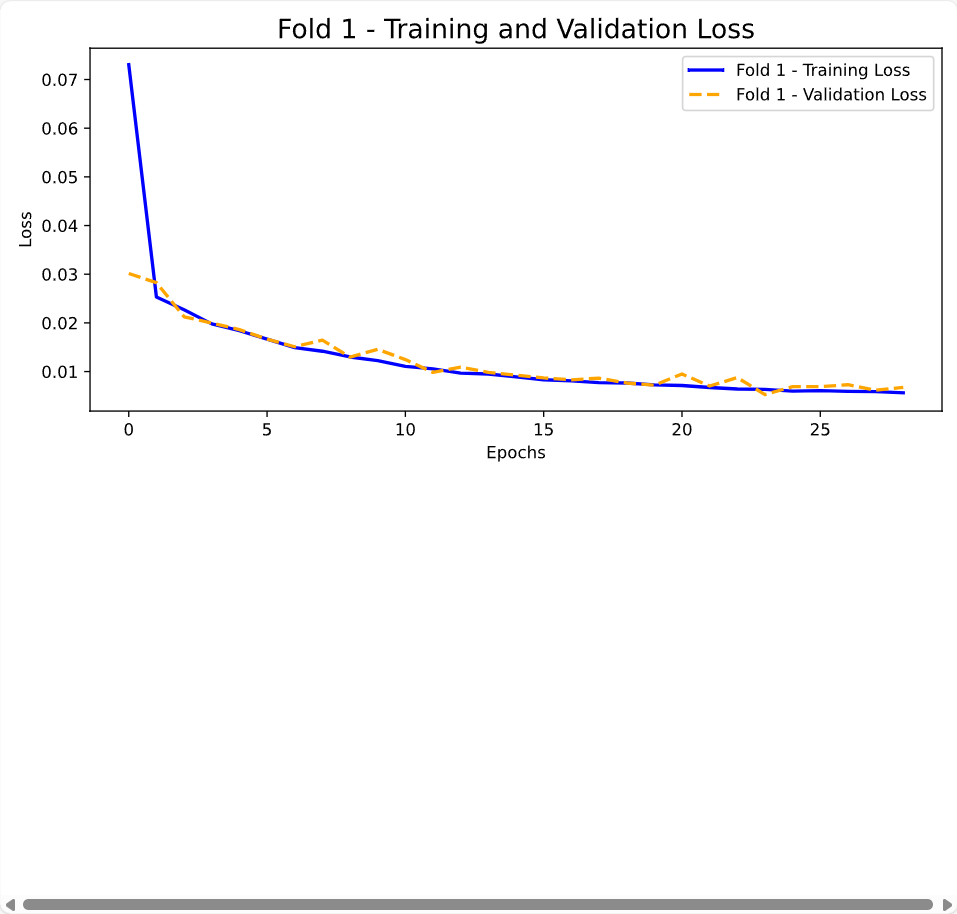

30/30 [==============================] - 0s 12ms/step


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_14308\2101943180.py:38: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_14308\2101943180.py:38: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_14308\2101943180.py:38: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_14308\2101943180.py:38: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_14308\2101943180.py:38: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public

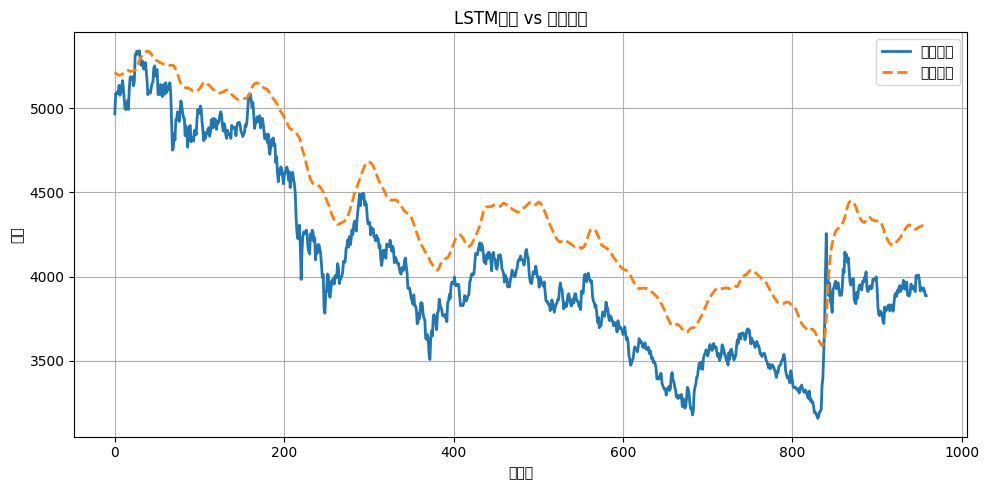

📊 模型评估（交叉验证平均）：
Mean MSE: nan
Mean RMSE: nan
Mean MAE: nan
Mean R²: nan

✅ 建议优化方向：
1. 尝试加入更多外部特征（宏观指标、政策预期等）
2. 尝试使用 Attention、GRU、或 Transformer 替代 LSTM
3. 增加模型保存频率，支持线上实时预测
4. 分板块建模或区间建模，提高个股适应性


d:\anaconda\envs\tf_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\tf_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ===== 1. 项目简介 =====
print("📌 项目名称：基于LSTM的沪深300股价预测")
print("📅 模型训练时间：你自己加上时间戳哦")
print("📈 使用模型：Keras Sequential LSTM x2 + Dropout + Dense")
print("📦 数据增强：平滑 + 加噪 + 时间错位")

# ===== 2. 数据维度和基本信息 =====
print(f"训练样本数（增强前）：{3836}")
print(f"训练样本数（增强后）：{23016}")
print(f"LSTM 时间步长：{60}")
print(f"特征维度数：{11}")

# ===== 3. 模型结构展示 =====
model.summary()

# ===== 4. 可视化一组 Fold 的训练损失（loss曲线已经保存过） =====
from IPython.display import Image, display
display(Image(filename='c:/Users/钱梓磊/Desktop/507project/figures/loss_fold_1.png'))  # 具体保存的路径

# ===== 5. 在测试集上做预测并反归一化 =====
final_predictions = model.predict(X_test)
final_predicted_prices = scaler_y.inverse_transform(final_predictions)
final_real_prices = scaler_y.inverse_transform(y_test)

# ===== 6. 绘图：预测 vs 实际 =====
plt.figure(figsize=(10, 5))
plt.plot(final_real_prices, label='真实价格', linewidth=2)
plt.plot(final_predicted_prices, label='预测价格', linestyle='--', linewidth=2)
plt.title('LSTM预测 vs 真实股价')
plt.xlabel('时间步')
plt.ylabel('股价')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== 7. 汇总评价指标（交叉验证） =====
print("📊 模型评估（交叉验证平均）：")
print(f"Mean MSE: {np.mean(mse_scores):.2f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.2f}")
print(f"Mean MAE: {np.mean(mae_scores):.2f}")
print(f"Mean R²: {np.mean(r2_scores):.4f}")

# ===== 8. 下一步建议 =====
print("\n✅ 建议优化方向：")
print("1. 尝试加入更多外部特征（宏观指标、政策预期等）")
print("2. 尝试使用 Attention、GRU、或 Transformer 替代 LSTM")
print("3. 增加模型保存频率，支持线上实时预测")
print("4. 分板块建模或区间建模，提高个股适应性")


In [16]:
import os
print("当前工作路径是：", os.getcwd())


当前工作路径是： c:\Users\钱梓磊\Desktop\507project


In [20]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 60, 50)            12400     
                                                                 
 dropout_22 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_23 (Dropout)        (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 32651 (127.54 KB)
Trainable params: 32651 (127.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
